# Wrapping Libraries - VBMicrolensing Example

This notebook is part of a series demonstrating how users can add support for their own simulation packages by adding simple wrappers. The example covered in this notebook is the [VBMicrolensing package](https://github.com/valboz/VBMicrolensing). Note that the VBMicrolensing package is not installed as part of the default LightCurveLynx installation. Users will need to manually install VBMicrolensing via pip (e.g. `pip install VBMicrolensing`) in order to run this notebook.


## VBMicrolensing

[VBMicrolensing](https://github.com/valboz/VBMicrolensing) is a package for simulating gravitational microlensing events. It provides a comprehensive set of microlensing events and parameters. In this tutorial, we consider applying just a pure Paczynski/point-source point-lens (PSPL) model, without any additional effects, as computed by the `PSPLLightCurve` function. This function takes a *list* of parameters and an array of times. It returns an array of magnifications.

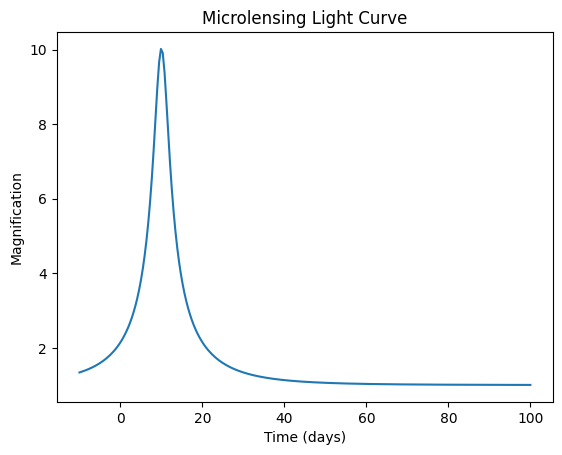

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import VBMicrolensing

# Create an instance of the VBMicrolensing class
VBM = VBMicrolensing.VBMicrolensing()

# Define parameters for the microlensing event.
u_0 = 0.1  # Minimum impact parameter
t_E = 20.0  # Einstein timescale (in days)
microlensing_t0 = 10.0  # Time of maximum magnification (in days)

# Generate a time array
times = np.linspace(-10, 100, 250)  # Time from -10 to 100 days

# Calculate the magnification due to microlensing using the parameterization described in:
# https://github.com/valboz/VBMicrolensing/blob/main/docs/python/LightCurves.md
params = [np.log(u_0), np.log(t_E), microlensing_t0]
magnification = VBM.PSPLLightCurve(params, times)[0]

plt.plot(times, magnification)
plt.xlabel("Time (days)")
plt.ylabel("Magnification")
plt.title("Microlensing Light Curve")
plt.show()

## VBMicrolensing as an Effect

Since VBMicrolensing produces magnifications of the background object instead of fluxes, we can use it as an effect. This approach will allow us to apply microlensing to any type of background object (e.g., a fixed brightness source, an AGN, or a supernova). To implement a new effect, we have to create three functions:
1) The ``__init__()`` function sets up all the internal data and registers the parameters.
2) The ``apply()`` function applies this effect to an SED.
3) The ``apply_bandflux()`` function applies this effect to a bandflux.

In [2]:
from lightcurvelynx.effects.effect_model import EffectModel


class SimpleMicrolensing(EffectModel):
    """A simple microlensing effect that can be applied to basic models. For more
    complex models, such as those blended by the microlensing event, it is recommended
    to create a new physical model. This model is a pure Paczynski/point-source point-lens
    (PSPL) model, without any additional effects.

    References
    ----------
    * V. Bozza, MNRAS 408 (2010) 2188: general algorithm for binary lensing;
    * V. Bozza, E. Bachelet, F. Bartolic, T. Heintz, A. Hoag, M. Hundertmark, MNRAS 479 (2018) 5157:
    BinaryMag2 function, Extended-Source-Point-Lens methods;
    * V. Bozza, E. Khalouei and E. Bachelet, MNRAS 505 (2021) 126: astrometry, generalized limb darkening,
    Keplerian orbital motion;
    * V. Bozza, v. Saggese, G. Covone, P. Rota & J. Zhang, A&A 694 (2025) 219: multiple lenses.

    Attributes
    ----------
    VBM : VBMicrolensing
        The microlensing model.

    Parameters
    ----------
    microlensing_t0 : parameter
        The time of the microlensing peak, in days.
    u_0 : parameter
        Impact parameter, distance from the source at time
        of peak in Einstein radii.
    t_E : parameter
        Einstein timescale, in days.
    **kwargs : dict, optional
        Any additional keyword arguments.
    """

    def __init__(self, microlensing_t0, u_0, t_E, **kwargs):
        # Create the microlensing model once.
        self.VBM = VBMicrolensing.VBMicrolensing()

        super().__init__(**kwargs, rest_frame=False)
        self.add_effect_parameter("microlensing_t0", microlensing_t0)
        self.add_effect_parameter("u_0", u_0)
        self.add_effect_parameter("t_E", t_E)

    def apply(
        self,
        flux_density,
        times=None,
        wavelengths=None,
        *,
        microlensing_t0=None,
        u_0=None,
        t_E=None,
        **kwargs,
    ):
        """Apply the effect to observations (flux_density values).

        Parameters
        ----------
        flux_density : numpy.ndarray
            A length T X N matrix of flux density values (in nJy).
        times : numpy.ndarray, optional
            A length T array of times (in MJD).
        wavelengths : numpy.ndarray, optional
            A length N array of wavelengths (in angstroms). Not used for this effect.
        microlensing_t0 : float
            The time of the microlensing peak, in days.
        u_0 : float
            Impact parameter, distance from the source at time
            of peak in Einstein radii.
        t_E : float
            Einstein timescale, in days.
        **kwargs : `dict`, optional
           Any additional keyword arguments, including any additional
           parameters needed to apply the effect.

        Returns
        -------
        flux_density : numpy.ndarray
            A length T x N matrix of flux densities after the effect is applied (in nJy).
        """
        # Calculates the PSPL magnification at different times with parameters in pr
        pr = [np.log(u_0), np.log(t_E), microlensing_t0]
        vbm_results = self.VBM.PSPLLightCurve(pr, times)
        magnifications = np.asarray(vbm_results[0])

        flux_density = flux_density * magnifications[:, np.newaxis]
        return flux_density

    def apply_bandflux(
        self,
        bandfluxes,
        *,
        microlensing_t0=None,
        u_0=None,
        t_E=None,
        times=None,
        filters=None,
        **kwargs,
    ):
        """Apply the effect to band fluxes.

        Parameters
        ----------
        bandfluxes : numpy.ndarray
            A length T array of band fluxes (in nJy).
        times : numpy.ndarray, optional
            A length T array of times (in MJD).
        filters : numpy.ndarray, optional
            A length N array of filters. Not used for this effect.
        microlensing_t0 : float
            The time of the microlensing peak, in days.
        u_0 : float
            Impact parameter, distance from the source at time
            of peak in Einstein radii.
        t_E : float
            Einstein timescale, in days.
        **kwargs : `dict`, optional
           Any additional keyword arguments, including any additional
           parameters needed to apply the effect.

        Returns
        -------
        bandfluxes : numpy.ndarray
            A length T array of band fluxes after the effect is applied (in nJy).
        """
        # Calculates the PSPL magnification at different times with parameters in pr
        pr = [np.log(u_0), np.log(t_E), microlensing_t0]
        vbm_results = self.VBM.PSPLLightCurve(pr, times)

        # array of magnifications at each time in time_stamp
        bandfluxes = bandfluxes * np.asarray(vbm_results[0])

        return bandfluxes

### The Init Function

The ``__init__()`` function starts by creating a ``VBMicrolensing`` object that can be re-used for each application. It then registers the three settable parameters (``microlensing_t0``, ``u_0``, and ``t_E``) used in this example. In general the VBMicrolensing package supports a much richer set of models and parameters. We limit the scope of the simulation for the simplicity of the example.

### The Apply Function

The ``apply()`` function places the parameters into an array, calls the ``PSPLLightCurve`` function, and applies the magnifications to the SED array. Note that, unlike with custom models, the parameters are passed via function arguments. This is because the parameters are registered and stored in the model node. The model node passes the parameter values when it applies the effect.

### The Apply Bandlfux Function

The ``apply_bandflux()`` function is nearly identical to the ``apply()`` function. Instead of multiplying the SED by the magnification, it multiplies the bandfluxes.


## Using the Effect in a Simulation

Once we define a ``Microlensing`` effect object, we can use it in the general LightCurveLynx simulation framework. Let's look at how we can apply microlensing to a constant model, such as a star. We start by defining the constant model (lensed object).

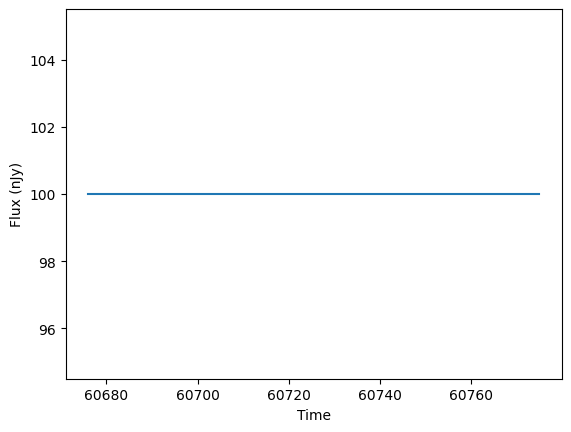

In [3]:
from lightcurvelynx.models.basic_models import ConstantSEDModel

source = ConstantSEDModel(brightness=100.0)

t_start = 60676.0
times = np.arange(100.0) + t_start
wavelengths = np.array([7000.0])
fluxes = source.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes)
plt.xlabel("Time")
plt.ylabel("Flux (nJy)")
plt.show()

Now we add a microlensing effect.  As you can see, the microlensing introduces a magnification 20.0 days after the start of the light curve.

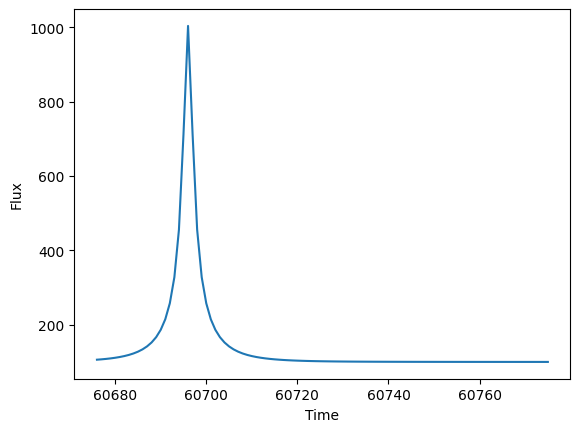

In [4]:
ml_effect = SimpleMicrolensing(microlensing_t0=t_start + 20.0, u_0=0.1, t_E=10.0)
source.add_effect(ml_effect)

fluxes = source.evaluate_sed(times, wavelengths)

plt.plot(times, fluxes)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.show()

## Conclusion

This notebook shows how we can create a basic wrapper for the VBMicrolensing effect. A more fully featured version of the code can be found in ``effects/microlensing.py``. It includes:
* additional data validation, and
* the ability to randomly apply microlensing with a given probability.

For a more comprehensive demo of how to apply VBMicrolensing effects, see the microlensing notebook.